In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import pickle
import numpy as np
f1 = open('data/split_weight_0.60_0.30_0.10_aug_to_1875_down_sample_False_instance0-9/train_data0', 'rb')
# X_sequence_train, X_feature_train, X_image_train, X_uncertainty_map_train, Y_train = pickle.load(f1)
X_sequence_train, X_feature_train, Y_train = pickle.load(f1)
f1.close()
f2 = open('data/split_weight_0.60_0.30_0.10_aug_to_1875_down_sample_False_instance0-9/val_data', 'rb')
# X_sequence_val, X_feature_val, X_image_val, X_uncertainty_map_val, Y_val = pickle.load(f2)
X_sequence_val, X_feature_val, Y_val = pickle.load(f2)
f2.close()
f3 = open('data/split_weight_0.60_0.30_0.10_aug_to_1875_down_sample_False_instance0-9/test_data', 'rb')
# X_sequence_test, X_feature_test, X_image_test, X_uncertainty_map_test, Y_test = pickle.load(f3)
X_sequence_test, X_feature_test,  Y_test = pickle.load(f3)
f3.close()

from keras_preprocessing.sequence import pad_sequences
X_sequence_train_paded = pad_sequences(X_sequence_train, dtype='float', padding='post', value = np.nan)
X_sequence_val_paded = pad_sequences(X_sequence_val, dtype='float', padding='post', value = np.nan)
X_sequence_test_paded = pad_sequences(X_sequence_test, dtype='float', padding='post', value = np.nan)
# 先pad再预处理，因为pad可以把array的list转为ndarray

from util import preprocess
X_sequence_train_trimed = preprocess(X_sequence_train_paded)
X_sequence_val_trimed = preprocess(X_sequence_val_paded)
X_sequence_test_trimed = preprocess(X_sequence_test_paded)

X_feature_train = np.array(X_feature_train)
X_feature_val = np.array(X_feature_val)
X_feature_test = np.array(X_feature_test)
Y_train = np.array(Y_train)-1 # 文件夹名从1开始但是标签从0开始
Y_val = np.array(Y_val)-1
Y_test = np.array(Y_test)-1

def stack_channel(images, uncertainty_maps):
    images_with_uncertainty = []
    for image, map in zip(images, uncertainty_maps):
        images_with_uncertainty.append(np.stack([image,map],axis=2))
    return np.array(images_with_uncertainty)

# X_image_with_uncertainty_train = stack_channel(X_image_train, X_uncertainty_map_train)
# X_image_with_uncertainty_val = stack_channel(X_image_val, X_uncertainty_map_val)
# X_image_with_uncertainty_test = stack_channel(X_image_test, X_uncertainty_map_test)

def build_channel(data):
    X = []
    for image in data:
        X.append(image.reshape(128, 128, 1))
    return X
# X_image_train = np.array(build_channel(X_image_train))
# X_image_val = np.array(build_channel(X_image_val))
# X_image_test = np.array(build_channel(X_image_test))

(128, 128)


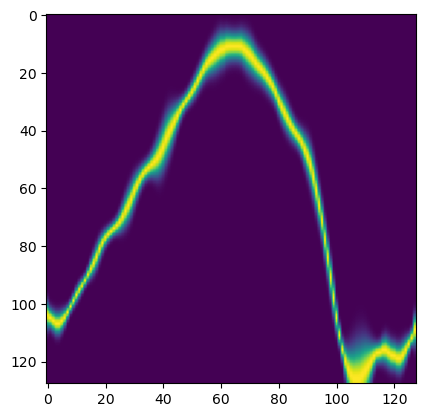

In [15]:
import matplotlib.pyplot as plt
plt.imshow(X_image_with_uncertainty_train[0][:,:,1])
print(X_image_with_uncertainty_train[0][:,:,1].shape)

In [3]:
from math import isnan
def remove_error_data(X_image, X_map, X_feature, X_sequence, Y):
    result_image = []
    result_map = []
    result_feature = []
    result_sequence = []
    result_Y = []
    error_count = 0
    for i, map in enumerate(X_map):
        if isnan(np.sum(map[:,:,1])):
            error_count += 1
        else:
            result_image.append(X_image[i])
            result_map.append(X_map[i])
            result_feature.append(X_feature[i])
            result_sequence.append(X_sequence[i])
            result_Y.append(Y[i])
    print('error count:%d'%error_count)
    return np.array(result_image),np.array(result_map),np.array(result_feature),np.array(result_sequence),np.array(result_Y)
X_image_train, X_image_with_uncertainty_train, X_feature_train, X_sequence_train_trimed, Y_train = \
remove_error_data(X_image_train, X_image_with_uncertainty_train, X_feature_train, X_sequence_train_trimed, Y_train)
X_image_val, X_image_with_uncertainty_val, X_feature_val, X_sequence_val_trimed, Y_val = \
remove_error_data(X_image_val, X_image_with_uncertainty_val, X_feature_val, X_sequence_val_trimed, Y_val)
X_image_test, X_image_with_uncertainty_test, X_feature_test, X_sequence_test_trimed, Y_test = \
remove_error_data(X_image_test, X_image_with_uncertainty_test, X_feature_test, X_sequence_test_trimed, Y_test)

error count:7
error count:6
error count:2


In [3]:
Y_train_one_hot = keras.utils.to_categorical(Y_train, num_classes=11)
Y_val_one_hot = keras.utils.to_categorical(Y_val, num_classes=11)
Y_test_one_hot = keras.utils.to_categorical(Y_test, num_classes=11)

In [8]:
print(X_feature_test[0])

[0.620709   0.43655089]


In [6]:
f = open('data/split_weight_0.60_0.30_0.10_aug_to_1875_down_sample_False_instance0-9/class_weights0', 'rb')
train_weight, test_weight = pickle.load(f)
f.close()
print(train_weight)

[0.72226502 0.83259325 1.         1.         0.16617921 0.69264869
 0.85890976 1.         1.         1.         1.        ]


In [7]:
from mix_models import rnn_with_feature
from mix_models import rnn_with_feature_2
from mix_models import cnn_with_feature_1
from mix_models import cnn_with_feature_2
# from mix_models import multi_input_model


# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=860,
#     decay_rate=0.85)

# boundaries = [2000]
    # values = [1e-3, 1e-4]
    # lr_schedule= tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    # boundaries, values, name=None
    # )

# strategy = tf.distribute.MirroredStrategy(['GPU:1'])
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
# with strategy.scope():

def multi_input_model(sequence_shape, image_shape, feature_shape, num_classes, cnn_lr_lamd=5):

    sequence_inputs = keras.Input(shape=sequence_shape, name='sequence')
    masking_layer = layers.Masking(mask_value=0, name='mask')
    x1 = masking_layer(sequence_inputs)
    x1 = layers.Bidirectional(layers.GRU(128, return_sequences=True, name='GRU1', trainable=False), name='Bidirectional_1',trainable=False)(x1)
    x1 = layers.Bidirectional(layers.GRU(64, name='GRU2', trainable=False), name='Bidirectional_2', trainable=False)(x1)
    x1 = layers.Dropout(0.4)(x1)
    x1 = layers.Dense(128, activation="relu", name='rnn_dense_1', trainable=False)(x1)
    x1 = layers.Dropout(0.4)(x1)
    x1 = layers.Dense(32, activation="relu", name='rnn_dense_2', trainable=False)(x1)

    image_inputs = keras.Input(shape=image_shape, name='image')
    x2 = layers.Rescaling(scale=1.0 / 255)(image_inputs)
    x2 = layers.Conv2D(filters=4, kernel_size=(7,7), strides=1, activation="relu", padding='same')(x2)
    x2 = layers.Conv2D(filters=4, kernel_size=(5,5), strides=1, activation="relu", padding='same')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3) ,strides=2)(x2)
    x2 = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(256, activation="relu", kernel_regularizer='l1')(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(32, activation="relu", kernel_regularizer='l1')(x2)

    feature_inputs = keras.Input(shape=feature_shape, name='feature')
    x3 = feature_inputs
    x3 = layers.Dense(64, activation="relu", name='feature_dense_1', trainable=False)(x3)
    x3 = layers.Dense(32, activation="relu",  name='feature_dense_2', trainable=False)(x3)

    x = layers.concatenate([x1, x2, x3])

    outputs = layers.Dense(num_classes, activation="softmax", name='mix_final_dense')(x)
    model = keras.Model(inputs=[sequence_inputs, image_inputs, feature_inputs], outputs=outputs)
    return model

# model = multi_input_model(sequence_shape=(None, 3), image_shape=(128, 128, 1), 
#                         feature_shape=(2,), num_classes=11, cnn_lr_lamd=10)
model = rnn_with_feature(sequence_shape=(None, 3),feature_shape=(2,), num_classes=11)
# model = rnn_with_feature2(sequence_shape=(None, 3),feature_shape=(1,), num_classes=11)
# model = cnn_with_feature_3(image_shape=(128, 128, 1), feature_shape=(2,), num_classes=11)
# model = cnn(image_shape=(128, 128, 1), num_classes=11)
# model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    # loss="sparse_categorical_crossentropy",
    # loss=categorical_focal_loss(alpha=np.ones(11)),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    # metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
    run_eagerly=False,
)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath='models/rnn_with_feature_equal/model_{epoch}',
    save_freq='epoch'),
  keras.callbacks.TensorBoard(log_dir='models/rnn_with_feature_equal/logs')
]

2023-03-28 16:40:47.705491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 16:40:48.210490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22064 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:73:00.0, compute capability: 8.6


In [ ]:
# X_train = {'sequence':X_sequence_train_trimed, 'image':X_image_train, 'feature':X_feature_train}
# X_val = {'sequence':X_sequence_val_trimed, 'image':X_image_val, 'feature':X_feature_val}

X_train = {'sequence':X_sequence_train_trimed, 'feature':X_feature_train}
X_val = {'sequence':X_sequence_val_trimed, 'feature':X_feature_val}

# map_train = np.array(build_channel(X_image_with_uncertainty_train[:,:,:,1]))
# map_val = np.array(build_channel(X_image_with_uncertainty_val[:,:,:,1]))
# X_train = {'sequence':X_sequence_train_trimed, 'image':map_train, 'feature':X_feature_train}
# X_val = {'sequence':X_sequence_val_trimed, 'image':map_val, 'feature':X_feature_val}

# X_train = {'sequence':X_sequence_train_trimed, 'image':X_image_with_uncertainty_train, 'feature':X_feature_train}
# X_val = {'sequence':X_sequence_val_trimed, 'image':X_image_with_uncertainty_val, 'feature':X_feature_val}

# X_train = {'sequence':X_sequence_train_trimed, 'feature0':X_feature_train[:,0], 'feature1':X_feature_train[:,1]}
# X_val = {'sequence':X_sequence_val_trimed, 'feature0':X_feature_val[:,0], 'feature1':X_feature_val[:,1]}
# model.load_weights('models/tmp_weights/rnn_weights_min_loss.h5', by_name=True)
model.fit(X_train, Y_train_one_hot, batch_size=32, epochs=30, 
        validation_data=(X_val, Y_val_one_hot), 
        #  class_weight=dict(enumerate(train_weight)),
        callbacks=callbacks)

In [ ]:
X_train = {'sequence':X_sequence_train_trimed, 'feature':X_feature_train}
X_val = {'sequence':X_sequence_val_trimed, 'feature':X_feature_val}
for i in range(0,10):
    model = rnn_with_feature(sequence_shape=(None, 3),feature_shape=(2,), num_classes=11)
    model.compile(
        optimizer=keras.optimizers.Adam(0.5e-3),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
        run_eagerly=False,
    )
    callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/rnn_with_feature_weight_x10/No%d/model_{epoch}'%i,
        save_freq='epoch'),
    keras.callbacks.TensorBoard(log_dir='models/rnn_with_feature_weight_x10/No%d/logs'%i)
    ]
    model.fit(X_train, Y_train_one_hot, batch_size=32, epochs=10, 
        validation_data=(X_val, Y_val_one_hot), 
        class_weight=dict(enumerate(train_weight)),
        callbacks=callbacks)

In [14]:
best_acc_list = [9,5,6,4,6,6,7,4,5,4]
min_loss_list = [6,6,7,5,4,6,8,4,5,4]
models = []
for i in range(0,10):
    lodaed_model = keras.models.load_model('models/rnn_with_feature_weight_x10/No%d/model_%d'%(i,min_loss_list[i]),compile=False)
    models.append(lodaed_model)

2023-03-28 20:20:07.186541: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-03-28 20:20:07.731651: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2023-03-28 20:20:08.695756: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2023-03-28 20:20:08.704583: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2023-03-28 20:20:08.742327: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _ou

3/3 [==============================] - 3s 31ms/step
(11, 11)
balanced_acc: 0.8556525721255077
Normalized confusion matrix
[[7.85659214e-01 3.85505012e-03 1.61912105e-02 1.37239784e-01
  3.08404009e-03 0.00000000e+00 3.85505012e-03 0.00000000e+00
  0.00000000e+00 4.78026214e-02 2.31303007e-03]
 [1.77777778e-03 8.18666667e-01 1.53777778e-01 8.88888889e-04
  8.00000000e-03 2.66666667e-03 7.11111111e-03 0.00000000e+00
  7.11111111e-03 0.00000000e+00 0.00000000e+00]
 [4.00000000e-02 9.33333333e-02 8.40000000e-01 2.00000000e-02
  6.66666667e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.88235294e-02 0.00000000e+00 0.00000000e+00 9.21568627e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.96078431e-02 0.00000000e+00]
 [1.77304965e-04 3.54609929e-04 0.00000000e+00 1.77304965e-04
  7.93085106e-01 5.37234043e-02 1.48404255e-01 8.86524823e-04
  5.31914894e-04 7.09219858e-04 1.95035461e-03]
 [0.00000000e+00 0

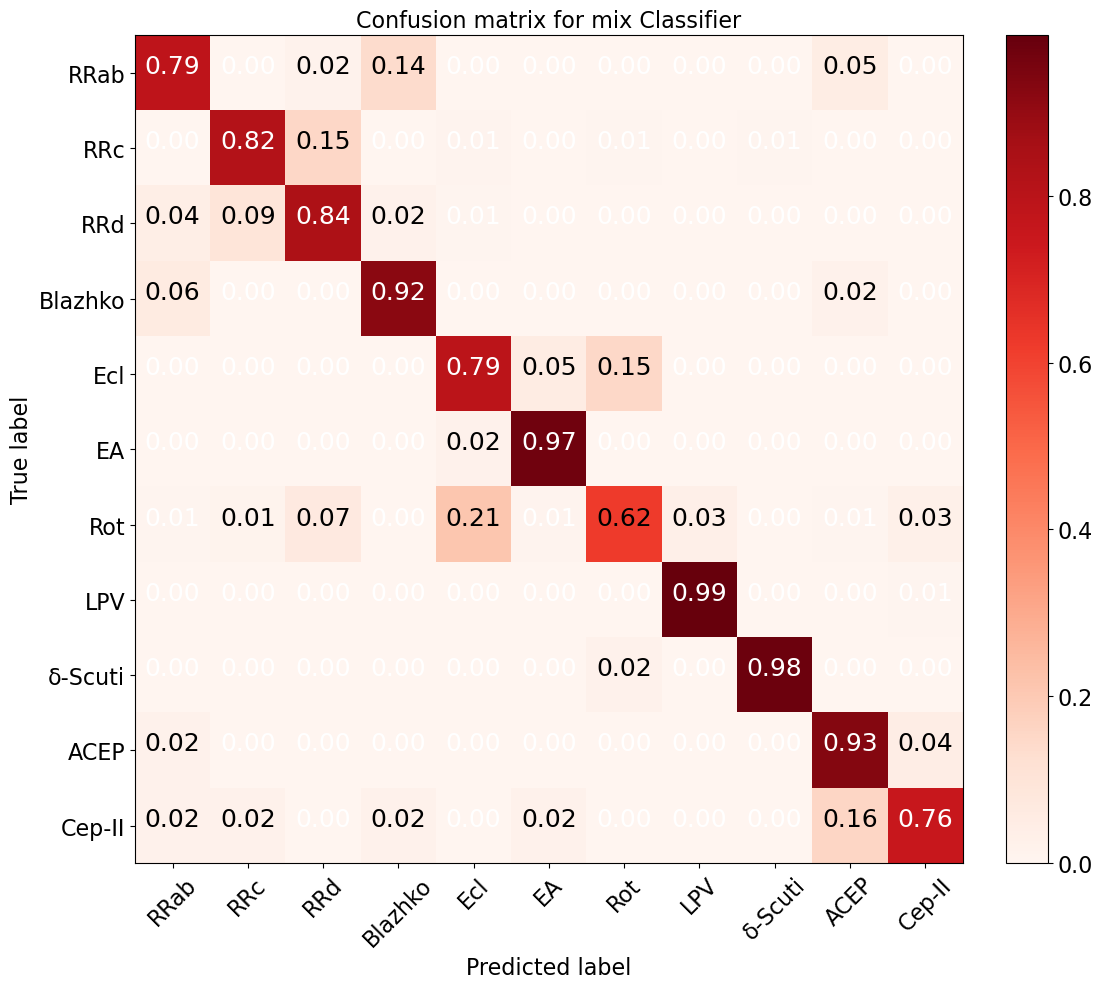

In [15]:
from util import generate_batch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

test_gen = generate_batch(X_sequence= X_sequence_test_trimed, 
                          X_feature= X_feature_test, 
                          Y= Y_test,batch_size= 128)      
y_label = Y_test


y_predict = np.array([])
for x_sequence, x_image, x_feature, y in test_gen:
    results = []
    for model in models:
        results.append(model.predict({'sequence':x_sequence, 
                                        # 'image':x_image,
                                        'feature':x_feature}))
    average_result = np.sum(results, axis=0)
    y_predict = np.concatenate([y_predict, np.argmax(average_result, axis=-1)])
y_label = y_label.astype(np.int32) 
y_predict = y_predict.astype(np.int32) 
cm = confusion_matrix(y_true=y_label, y_pred=y_predict, normalize='true')
print(cm.shape)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(values_format='.2g')
balanced_acc = 0
for i in range(0,11):
    balanced_acc += cm[i][i]
balanced_acc = balanced_acc / 11
print('balanced_acc:',balanced_acc)

classes = ['RRab', 'RRc','RRd', 'Blazhko','Ecl', 'EA' , 'Rot', 'LPV','δ-Scuti','ACEP', 'Cep-II']

from util import cm_plot

plotting = cm_plot(cm, classes_types=classes, classifier_model='mix Classifier', nClasses=11,
                    cmap=plt.cm.Blues)

In [6]:
loaded_model = keras.models.load_model('models/xnn_with_feature_test/model_5', compile=False)
loaded_model.save_weights('models/tmp_weights/rnn_weights_min_loss.h5')
loaded_model = keras.models.load_model('models/xnn_with_feature_test/model_2', compile=False)
loaded_model.save_weights('models/tmp_weights/rnn_weights_best_acc.h5')

2022-11-17 21:56:08.102756: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-17 21:56:08.510223: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-17 21:56:08.519724: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-17 21:56:09.134228: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-17 21:56:09.513510: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _ou

2023-03-28 15:56:01.202217: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-03-28 15:56:01.210597: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-03-28 15:56:01.353184: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2023-03-28 15:56:03.735375: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-03-28 15:56:03.743707: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_sh

3/3 [==============================] - 3s 33ms/step
Normalized confusion matrix
[[8.17270625e-01 4.62606014e-03 1.54202005e-02 1.13338473e-01
  3.85505012e-03 0.00000000e+00 3.85505012e-03 0.00000000e+00
  0.00000000e+00 3.93215112e-02 2.31303007e-03]
 [8.88888889e-03 8.05333333e-01 1.29777778e-01 8.88888889e-03
  8.88888889e-03 2.66666667e-03 9.77777778e-03 0.00000000e+00
  2.48888889e-02 0.00000000e+00 8.88888889e-04]
 [4.66666667e-02 1.20000000e-01 7.66666667e-01 6.66666667e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.74509804e-01 0.00000000e+00 3.92156863e-02 6.86274510e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.09219858e-04 5.31914894e-04 7.09219858e-04 3.54609929e-04
  7.72163121e-01 6.06382979e-02 1.58865248e-01 5.31914894e-04
  1.59574468e-03 1.77304965e-03 2.12765957e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+0

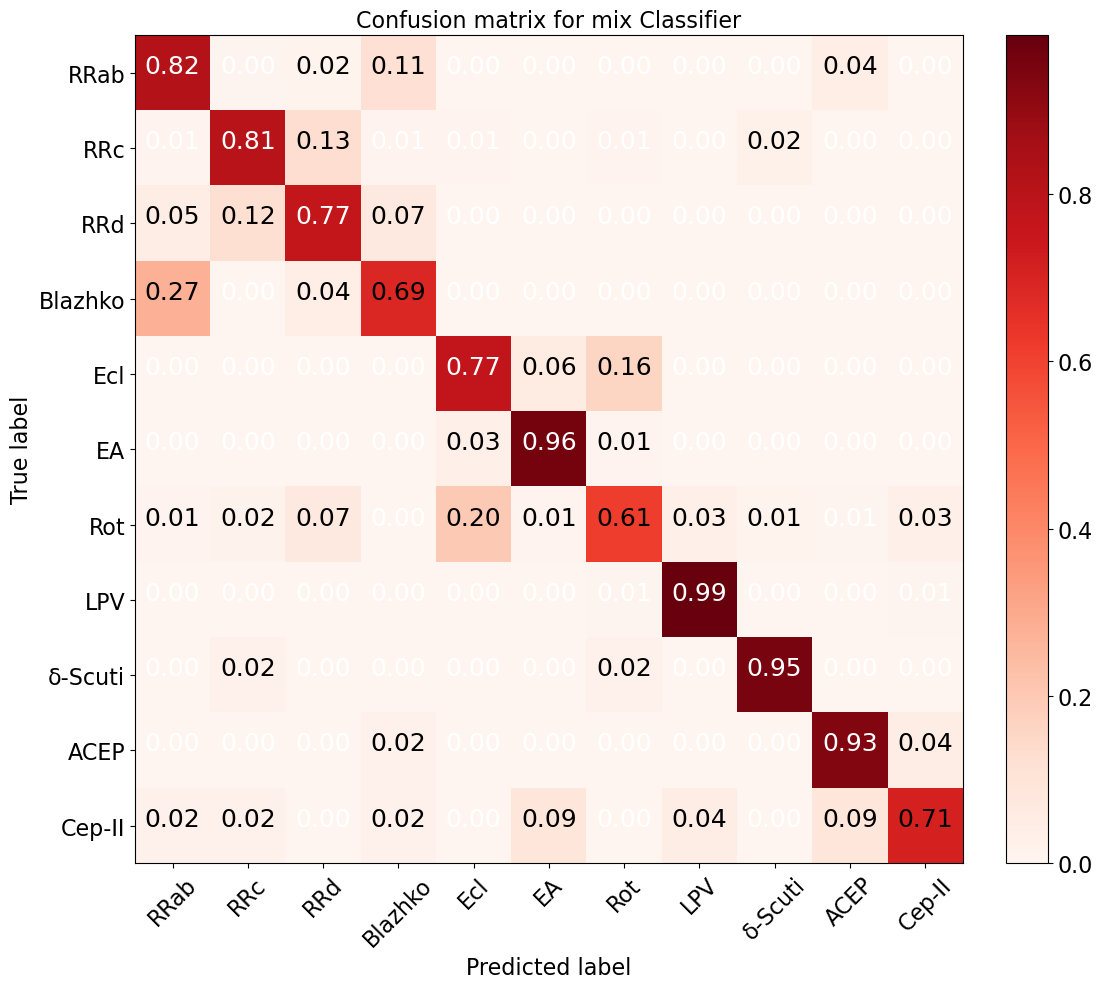

In [9]:
loaded_model = keras.models.load_model('models/rnn_with_feature_equal/model_6', compile=False)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from util import generate_batch

# test_gen = generate_batch(X_sequence=X_sequence_test_trimed,X_image=X_image_test,X_feature=X_feature_test, Y=Y_test, batch_size=128)      
test_gen = generate_batch(X_sequence=X_sequence_test_trimed,X_feature=X_feature_test, Y=Y_test, batch_size=128)      
y_label = Y_test

y_predict = np.array([])
for x_sequence, x_image, x_feature, y in test_gen:
    y_predict = np.concatenate([y_predict, 
            np.argmax(loaded_model.predict({
                                            'sequence':x_sequence, 
                                            'image':x_image,
                                            'feature':x_feature}), axis=-1)])
y_label = y_label.astype(np.int32) 
y_predict = y_predict.astype(np.int32) 
cm = confusion_matrix(y_true=y_label, y_pred=y_predict, 
                        # labels=[], 
                        # labels用于交换顺序
                        normalize='true')

classes = ['RRab', 'RRc','RRd', 'Blazhko','Ecl', 'EA' , 'Rot', 'LPV','δ-Scuti','ACEP', 'Cep-II']
from util import cm_plot
plotting = cm_plot(cm, classes_types=classes, classifier_model='mix Classifier', nClasses=11,
                    cmap=plt.cm.Blues)



In [10]:
import pickle
f = open('y_pre_and_y_label_equal', 'wb')
pickle.dump((y_predict,y_label), f)